Config

In [ ]:
import os
pwd = '<<>>'
max_length = 1024
features = 'both'

model_dir = os.path.join(pwd, f'logs/gte/release/gte-{max_length}-{features}')
pred_dir = os.path.join(pwd, f'data/predictions/gte/release/test_{max_length}_{features}_pred')

jsonl_path = os.path.join(model_dir, 'callback_log.jsonl')

from datasets import disable_caching, enable_caching
disable_caching()

Functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

def plot_training_curve(log_file, window=5, col='loss', x='epoch'):

    df = pd.read_json(log_file, lines=True)
    df = df.loc[ df[col].notna(), : ]

    df.loc[:,f'{col}ma'] = df.loc[:, col].rolling(window=window).mean()
    
    f = plt.figure(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    
    model_name = model_dir.split('/')[-1]
    plt.title(f"{model_name} training loss")
    plt.xlabel('epoch')
    plt.ylabel(col)

    # plt.xlim(0.0, 0.)
    # plt.ylim(0.0, 0.1)

    plt.plot(df[x], df[f'{col}ma'])

Training Curve

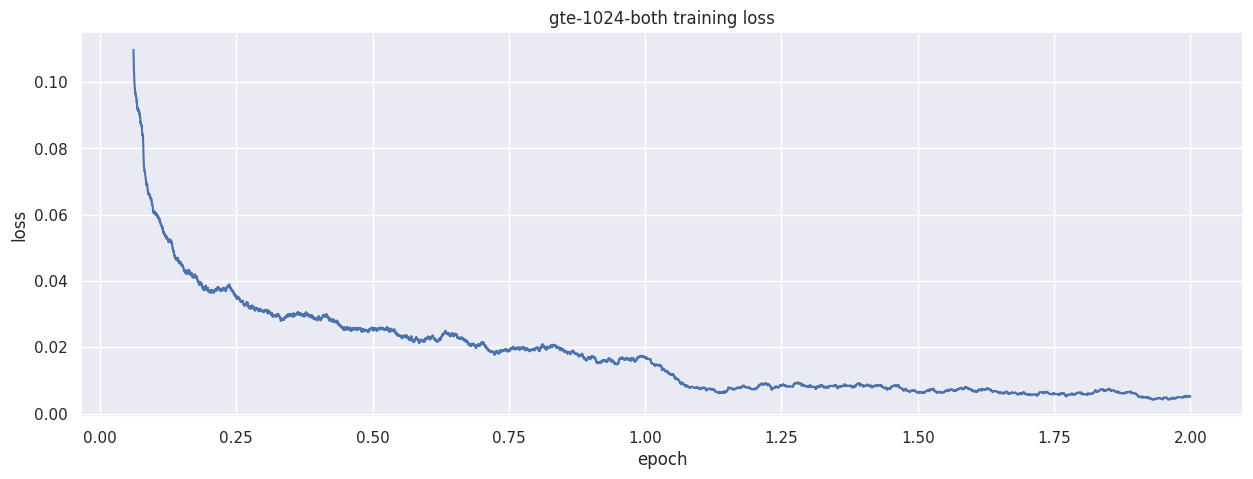

In [3]:
plot_training_curve(jsonl_path, window=1000, col='loss', x='epoch')

Test Evaluation

In [ ]:
from datasets import DatasetDict
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

def get_eval_metrics(pred_dir):
    ds = DatasetDict.load_from_disk(pred_dir)
    score_col = [x for x in ds['phishes'].features if x.startswith('score')][0]

    y_true, y_score = [], []
    for i, class_type in enumerate(ds):
        y_true.extend(ds[class_type]['labels'])
        y_score.extend(ds[class_type][score_col])

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auroc = roc_auc_score(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    eval_metrics = {
        'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 
        'auroc': auroc, 'precision': precision, 'recall': recall, 'auprc': auprc
    }

    return y_true, y_score, eval_metrics


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

def plot_roc_prc(eval_metrics):
    fpr = eval_metrics['fpr']
    tpr = eval_metrics['tpr']
    auroc = eval_metrics['auroc']
    recall = eval_metrics['recall']
    precision = eval_metrics['precision']
    auprc = eval_metrics['auprc']

    fig, axes = plt.subplots(1, 2, figsize=(20, 7), tight_layout=True)
    sns.lineplot(x=fpr, y=tpr, ax=axes[0])
    axes[0].set_title(f"ROC Curve with AUC: {auroc:.6f}")
    axes[0].set_xlabel('fpr')
    axes[0].set_ylabel('tpr')
    sns.lineplot(x=recall, y=precision, ax=axes[1])
    axes[1].set_title(f"Precision Recall Curve with AUC: {auprc:.6f}")
    axes[1].set_xlabel('recall')
    axes[1].set_ylabel('precision')

    plt.show()


import numpy as np
def plot_confusion_metrics(y_true, y_score):

    labels=['benigns', 'phishes']
    threshs = [0.3, 0.4, 0.5, 0.6, 0.7]
    n_threshs = len(threshs)

    fig, axes = plt.subplots(1, n_threshs, figsize=(5*n_threshs, 5), tight_layout=True)
    for i, thresh in enumerate(threshs):
        y_pred = (np.array(y_score) > thresh).astype('int')
        cm = confusion_matrix(y_true, y_pred)
        cr = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=axes[i], cbar=False)
        axes[i].set_title(f"Confusion Matrix @{thresh}. Avg-F1:{cr['macro avg']['f1-score']:.4f}")

    plt.show()

def plot_score_histograms(y_true, y_score):
    df = pd.DataFrame({'y_true': np.array(y_true), 'y_score': np.array(y_score)})
    df.y_true = df.y_true.replace(1, 'phish')
    df.y_true = df.y_true.replace(0, 'benign')
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 7), tight_layout=True, sharey=True)
    sns.histplot(df.loc[df.y_true == 'phish', 'y_score'], ax=axes[1], log=True, binwidth=0.025, color='salmon')
    axes[1].set_title(f"Phish prediction score histogram")
    axes[1].set_xlabel("score")
    axes[1].set_xlim(0.0, 1.0)
    sns.histplot(df.loc[df.y_true == 'benign', 'y_score'], ax=axes[0], log=True, binwidth=0.025, color='steelblue')
    axes[0].set_title(f"Benign prediction score histogram")
    axes[0].set_xlabel("score")
    axes[0].set_xlim(0.0, 1.0)

    plt.show()
    

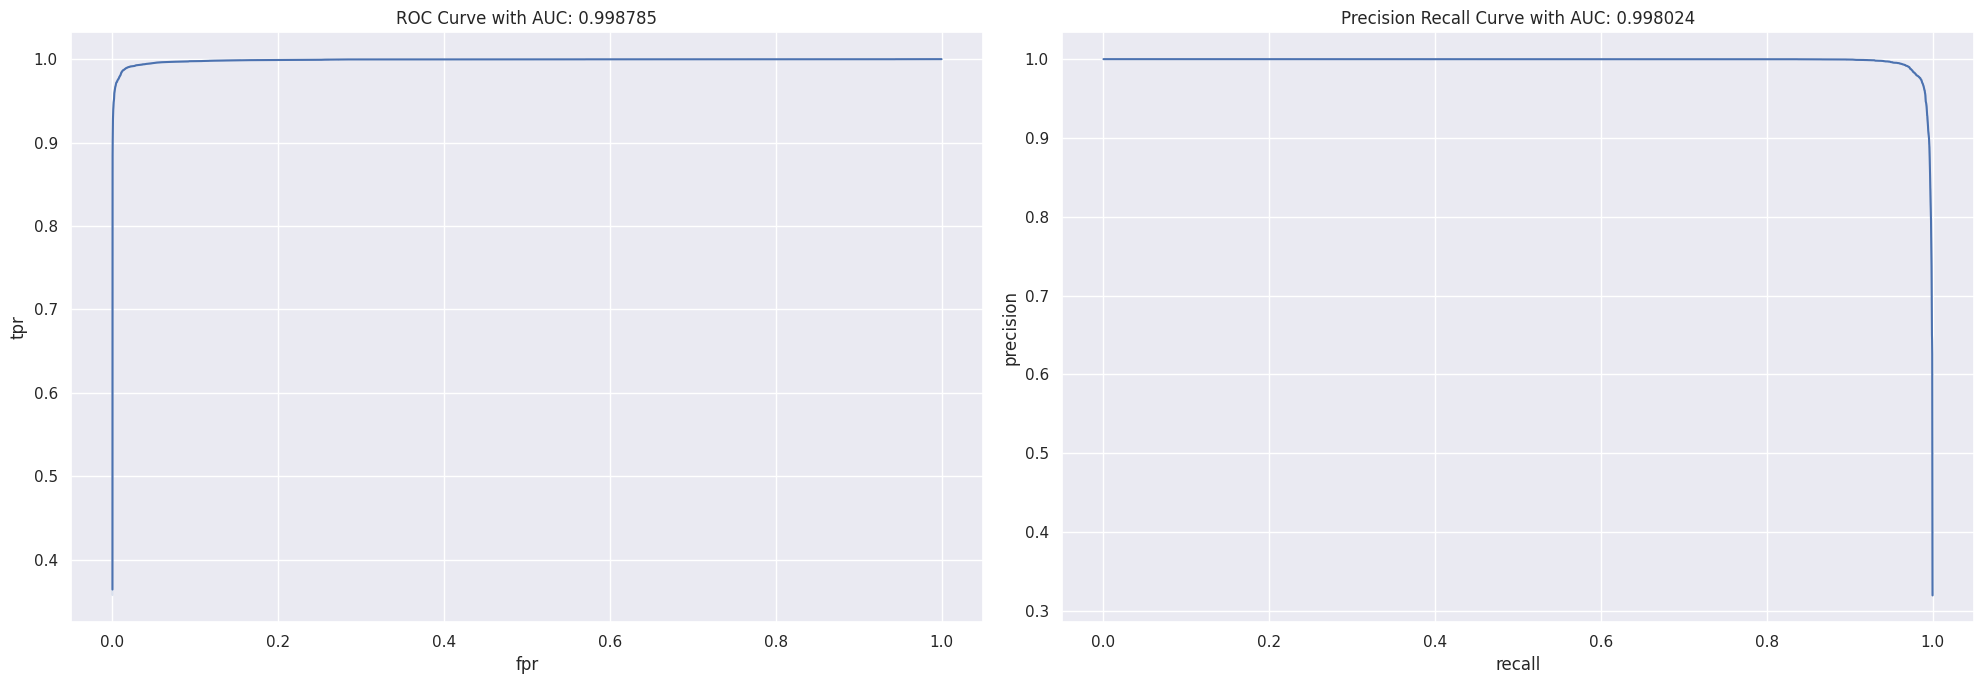

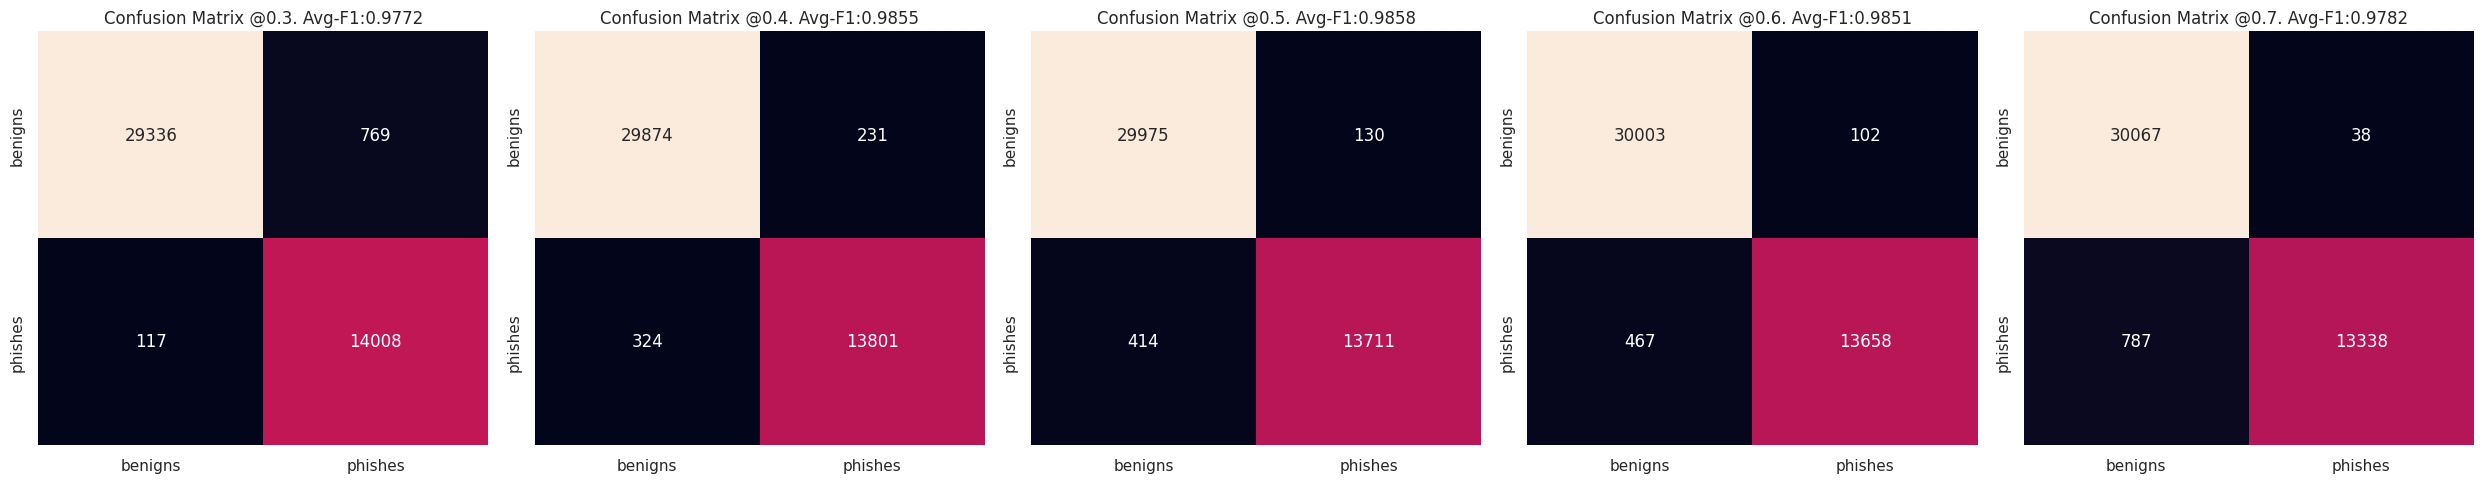

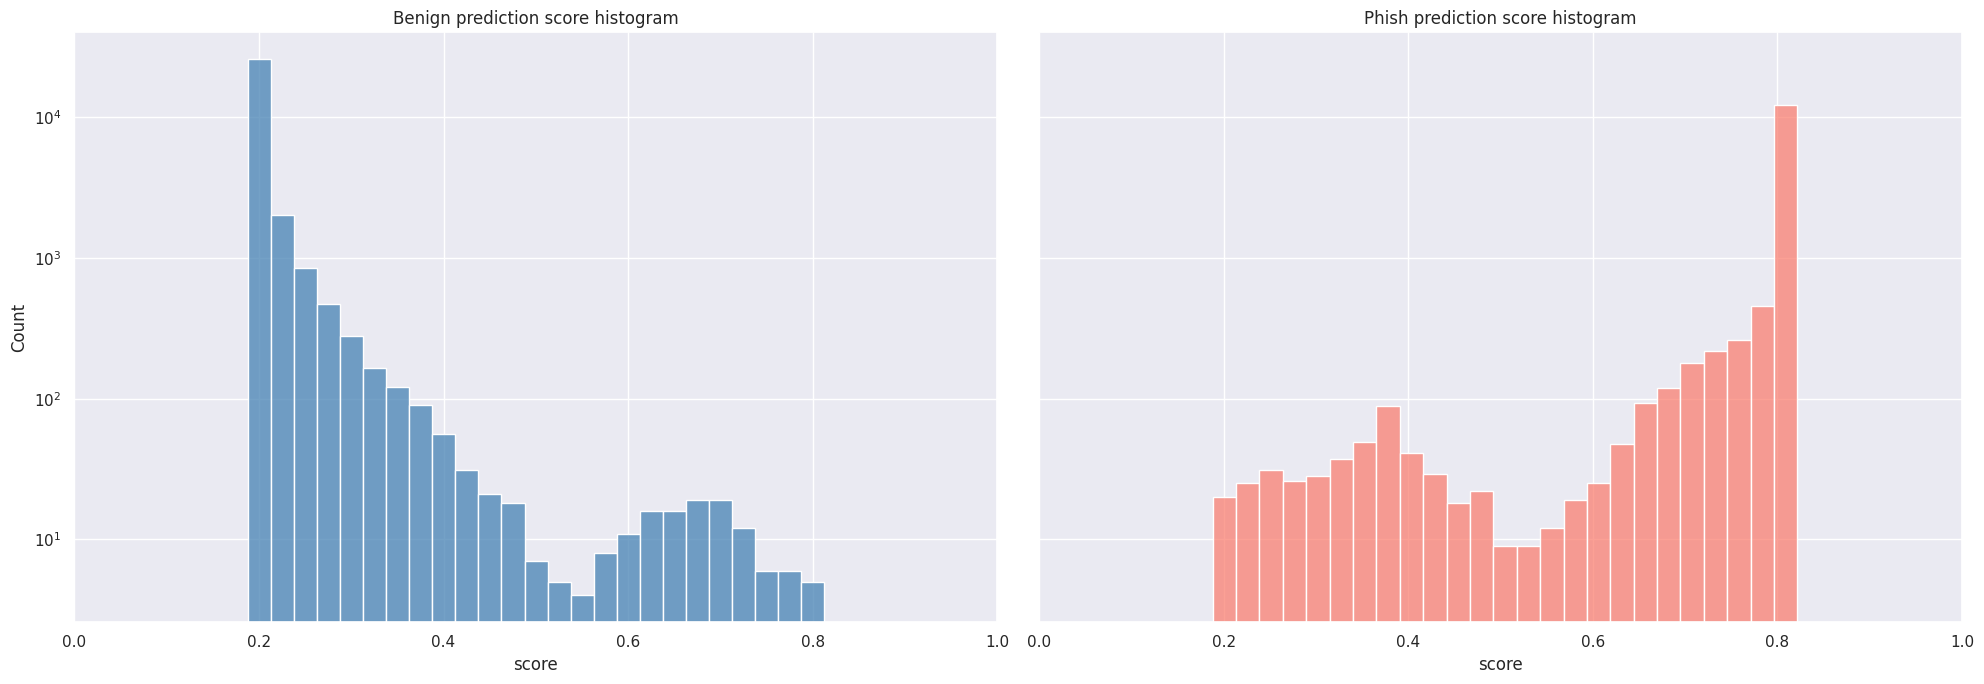

In [29]:
y_true, y_score, eval_metrics = get_eval_metrics(pred_dir)
plot_roc_prc(eval_metrics)
plot_confusion_metrics(y_true, y_score)
plot_score_histograms(y_true, y_score)